In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand

spark = SparkSession.builder.appName("dataSet").getOrCreate()
file = "heart_2020_cleaned.csv"
df = spark.read.csv(file, header=True, inferSchema=True)

columns_to_drop = ["Race", "MentalHealth", "PhysicalHealth"]
df = df.drop(*columns_to_drop)

from pyspark.sql.functions import stddev, mean, abs, col
bmi_stats = df.select(mean(col("BMI")).alias("mean_BMI"), stddev(col("BMI")).alias("stddev_BMI")).first()
mean_bmi = bmi_stats["mean_BMI"]
stddev_bmi = bmi_stats["stddev_BMI"]
sleep_time_stats = df.select(mean(col("SleepTime")).alias("mean_SleepTime"), stddev(col("SleepTime")).alias("stddev_SleepTime")).first()
mean_sleep_time = sleep_time_stats["mean_SleepTime"]
stddev_sleep_time = sleep_time_stats["stddev_SleepTime"]
threshold = 3
df = df.withColumn("z_score_BMI", abs((col("BMI") - mean_bmi) / stddev_bmi))
df = df.withColumn("z_score_SleepTime", abs((col("SleepTime") - mean_sleep_time) / stddev_sleep_time))
df = df.filter(col("z_score_BMI") <= threshold)
df = df.filter(col("z_score_SleepTime") <= threshold)
df = df.drop("z_score_BMI", "z_score_SleepTime")

df = df.dropna()

from pyspark.sql import functions as F

df = df.withColumn(
    'BMI_Category',
    F.when((df['BMI'] < 18.5), 'Low')
    .when((df['BMI'] >= 18.5) & (df['BMI'] < 24.9), 'Normal')
    .when((df['BMI'] >= 25.0) & (df['BMI'] < 29.9), 'Over')
    .when((df['BMI'] >= 30.0) & (df['BMI'] < 34.9), 'ObeseI')
    .when((df['BMI'] >= 35.0) & (df['BMI'] < 39.9), 'ObesityII')
    .otherwise('ObesityIII')
)
from pyspark.sql import functions as F
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

binary_features = ["HeartDisease", "AlcoholDrinking", "Stroke", "DiffWalking", "Smoking", "Diabetic", "PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"]

for column in binary_features:
    df = df.withColumn(column, F.when(df[column] == 'Yes', 1).otherwise(0))

df = df.withColumn("Sex", F.when(df["Sex"] == "Male", 1).otherwise(0))

df = df.withColumn("Diabetic", F.when(df["Diabetic"] == "No, borderline diabetes", 0).when(df["Diabetic"] == "Yes (during pregnancy)", 1).otherwise(df["Diabetic"]))


string_indexer = StringIndexer(inputCol="BMI_Category", outputCol="BMI_Category_Index")
model = string_indexer.fit(df)
df = model.transform(df)

string_indexer = StringIndexer(inputCol="AgeCategory", outputCol="AgeCategory_Index")
model = string_indexer.fit(df)
df = model.transform(df)

string_indexer = StringIndexer(inputCol="GenHealth", outputCol="GenHealth_Index")
model = string_indexer.fit(df)
df = model.transform(df)

columns_to_drop = ["BMI_Category", "AgeCategory", "GenHealth"]
df = df.drop(*columns_to_drop)

df_high = df.filter(df["HeartDisease"] == 0)
df_low = df.filter(df["HeartDisease"] == 1)

num_samples = df_low.count()

df_high_sampled = df_high.sample(False, num_samples / df_high.count(), seed=42)

df = df_high_sampled.union(df_low)

df.show()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/09 10:53:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+------------+-----+-------+---------------+------+-----------+---+--------+----------------+---------+------+-------------+----------+------------------+-----------------+---------------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|DiffWalking|Sex|Diabetic|PhysicalActivity|SleepTime|Asthma|KidneyDisease|SkinCancer|BMI_Category_Index|AgeCategory_Index|GenHealth_Index|
+------------+-----+-------+---------------+------+-----------+---+--------+----------------+---------+------+-------------+----------+------------------+-----------------+---------------+
|           0|26.45|      0|              0|     0|          0|  0|       0|               0|        5|     0|            1|         0|               0.0|              5.0|            3.0|
|           0|29.86|      1|              0|     0|          1|  0|       1|               0|        5|     0|            1|         0|               0.0|              7.0|            3.0|
|           0|21.16|      0|              0|     0|    

In [2]:
from pyspark.ml.feature import VectorAssembler

feature_columns = ["BMI", "Smoking", "AlcoholDrinking", "Stroke", "DiffWalking", 
                   "Sex", "Diabetic", "PhysicalActivity", "SleepTime", "Asthma", 
                   "KidneyDisease", "SkinCancer", "BMI_Category_Index", 
                   "AgeCategory_Index", "GenHealth_Index"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

output = assembler.transform(df)

output.printSchema()
output.head(1)

root
 |-- HeartDisease: integer (nullable = false)
 |-- BMI: double (nullable = true)
 |-- Smoking: integer (nullable = false)
 |-- AlcoholDrinking: integer (nullable = false)
 |-- Stroke: integer (nullable = false)
 |-- DiffWalking: integer (nullable = false)
 |-- Sex: integer (nullable = false)
 |-- Diabetic: integer (nullable = false)
 |-- PhysicalActivity: integer (nullable = false)
 |-- SleepTime: integer (nullable = true)
 |-- Asthma: integer (nullable = false)
 |-- KidneyDisease: integer (nullable = false)
 |-- SkinCancer: integer (nullable = false)
 |-- BMI_Category_Index: double (nullable = false)
 |-- AgeCategory_Index: double (nullable = false)
 |-- GenHealth_Index: double (nullable = false)
 |-- features: vector (nullable = true)



23/10/09 10:53:56 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Row(HeartDisease=0, BMI=26.45, Smoking=0, AlcoholDrinking=0, Stroke=0, DiffWalking=0, Sex=0, Diabetic=0, PhysicalActivity=0, SleepTime=5, Asthma=0, KidneyDisease=1, SkinCancer=0, BMI_Category_Index=0.0, AgeCategory_Index=5.0, GenHealth_Index=3.0, features=SparseVector(15, {0: 26.45, 8: 5.0, 10: 1.0, 13: 5.0, 14: 3.0}))]

In [3]:
final_data = output.select("features", "HeartDisease")
final_data.show()

+--------------------+------------+
|            features|HeartDisease|
+--------------------+------------+
|(15,[0,8,10,13,14...|           0|
|(15,[0,1,4,6,8,10...|           0|
|(15,[0,8,12,13,14...|           0|
|(15,[0,1,3,5,8,11...|           0|
|(15,[0,5,7,8,12],...|           0|
|(15,[0,1,3,5,8,9,...|           0|
|(15,[0,1,8,13,14]...|           0|
|(15,[0,7,8,12,13]...|           0|
|(15,[0,7,8,12,13,...|           0|
|(15,[0,5,8,13,14]...|           0|
|(15,[0,8],[26.22,...|           0|
|(15,[0,8,11,12,13...|           0|
|(15,[0,1,6,7,8,11...|           0|
|[23.67,1.0,0.0,1....|           0|
|[33.2,0.0,0.0,0.0...|           0|
|(15,[0,5,7,8,12,1...|           0|
|(15,[0,7,8,12,14]...|           0|
|(15,[0,4,7,8,12,1...|           0|
|(15,[0,5,7,8,13,1...|           0|
|(15,[0,1,2,7,8,11...|           0|
+--------------------+------------+
only showing top 20 rows



In [4]:
train_data, test_data = final_data.randomSplit([0.7, 0.3])


In [52]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# DecisionTreeClassifier Model
dt = DecisionTreeClassifier(labelCol="HeartDisease", featuresCol="features")

dt_model = dt.fit(train_data)

predictions = dt_model.transform(test_data)

predictions.show()

evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease")
auc = evaluator.evaluate(predictions)

print("AUC:", auc)


+--------------------+------------+---------------+--------------------+----------+
|            features|HeartDisease|  rawPrediction|         probability|prediction|
+--------------------+------------+---------------+--------------------+----------+
|(15,[0,1,2,3,7,8,...|           0|[3231.0,2698.0]|[0.54494855793557...|       0.0|
|(15,[0,1,2,3,7,8,...|           0|   [39.0,166.0]|[0.19024390243902...|       1.0|
|(15,[0,1,2,3,7,8,...|           0|[3231.0,2698.0]|[0.54494855793557...|       0.0|
|(15,[0,1,2,4,5,7,...|           0|  [186.0,127.0]|[0.59424920127795...|       0.0|
|(15,[0,1,2,4,5,8,...|           0|[3289.0,9249.0]|[0.26232253947998...|       1.0|
|(15,[0,1,2,4,5,8,...|           0| [776.0,2232.0]|[0.25797872340425...|       1.0|
|(15,[0,1,2,4,8,9,...|           0| [776.0,2232.0]|[0.25797872340425...|       1.0|
|(15,[0,1,2,4,8,12...|           0| [776.0,2232.0]|[0.25797872340425...|       1.0|
|(15,[0,1,2,5,7,8,...|           0|[8439.0,1431.0]|[0.85501519756838...|    

AUC: 0.6872546309527037


In [23]:
!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 60.6 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 KB 33.8 MB/s eta 0:00:00


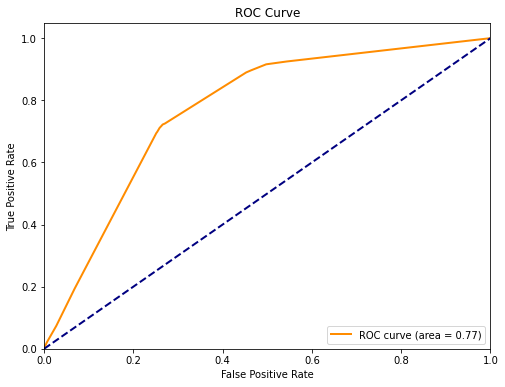

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_true = predictions.select("HeartDisease").rdd.flatMap(lambda x: x).collect()
y_prob = predictions.select("probability").rdd.map(lambda x: float(x[0][1])).collect()

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [12]:
param_map = dt_model.extractParamMap()
print(param_map)

{Param(parent='DecisionTreeClassifier_546febf9ae2e', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='DecisionTreeClassifier_546febf9ae2e', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='DecisionTreeClassifier_546febf9ae2e', name='featuresCol', doc='features column name.'): 'features', Param(parent='DecisionTreeClassifier_546febf9ae2e', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini',

In [17]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

predictions = dt_model.transform(test_data)

binary_evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease", metricName="areaUnderROC")

auc = binary_evaluator.evaluate(predictions)
print("AUC: " + str(auc))

multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", metricName="accuracy")

accuracy = multiclass_evaluator.evaluate(predictions)
print("Accuracy: " + str(accuracy))

recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedRecall"})
print("Recall: " + str(recall))


AUC: 0.6872546309527037


Accuracy: 0.7272266244057052


Recall: 0.7272266244057053


In [15]:
tree_structure = dt_model.toDebugString
print("Decision Tree Structure:\n" + tree_structure)

Decision Tree Structure:
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_546febf9ae2e, depth=5, numNodes=33, numClasses=2, numFeatures=15
  If (feature 13 in {4.0,6.0,8.0,9.0,10.0,11.0,12.0})
   If (feature 4 <= 0.5)
    If (feature 3 <= 0.5)
     Predict: 0.0
    Else (feature 3 > 0.5)
     Predict: 1.0
   Else (feature 4 > 0.5)
    If (feature 3 <= 0.5)
     If (feature 14 in {0.0,1.0,2.0})
      Predict: 0.0
     Else (feature 14 not in {0.0,1.0,2.0})
      If (feature 13 in {8.0,9.0,10.0,11.0,12.0})
       Predict: 0.0
      Else (feature 13 not in {8.0,9.0,10.0,11.0,12.0})
       Predict: 1.0
    Else (feature 3 > 0.5)
     Predict: 1.0
  Else (feature 13 not in {4.0,6.0,8.0,9.0,10.0,11.0,12.0})
   If (feature 14 in {2.0})
    If (feature 13 in {0.0,1.0,2.0,3.0,7.0})
     If (feature 5 <= 0.5)
      If (feature 3 <= 0.5)
       Predict: 0.0
      Else (feature 3 > 0.5)
       Predict: 1.0
     Else (feature 5 > 0.5)
      If (feature 6 <= 0.5)
       Predict: 0.0
     

In [16]:
feature_importances = dt_model.featureImportances
print("Feature Importances: " + str(feature_importances))

Feature Importances: (15,[3,4,5,6,13,14],[0.05045544964539487,0.12002734473621578,0.011929141659337592,0.0063615012548249,0.6617432322075275,0.1494833304966994])


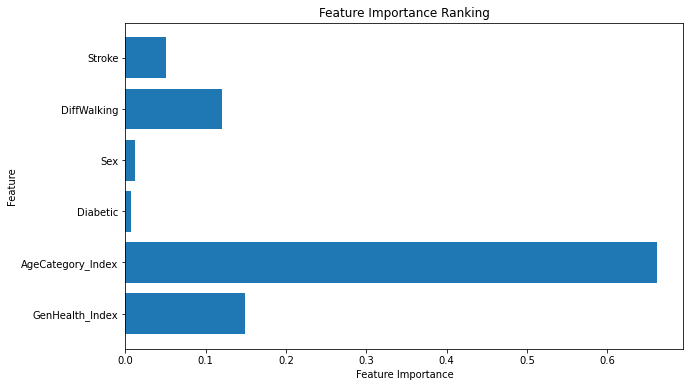

In [36]:
import matplotlib.pyplot as plt
import numpy as np

indices = [3, 4, 5, 6, 13, 14]  
importance_values = [0.05045544964539487, 0.12002734473621578, 0.011929141659337592, 0.0063615012548249, 0.6617432322075275, 0.1494833304966994]
feature_columns = ["BMI", "Smoking", "AlcoholDrinking", "Stroke", "DiffWalking", 
                   "Sex", "Diabetic", "PhysicalActivity", "SleepTime", "Asthma", 
                   "KidneyDisease", "SkinCancer", "BMI_Category_Index", 
                   "AgeCategory_Index", "GenHealth_Index"]

feature_names = [feature_columns[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importance_values)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Ranking')
plt.gca().invert_yaxis() 
plt.show()


In [55]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease", rawPredictionCol="prediction", metricName="areaUnderROC")

auc = evaluator.evaluate(predictions)

print("Accuracy: {:.5}".format(auc))


Accuracy: 0.72713
